# Example
---

Play a game that we get paid 1 for each H above some threshold value. Say we flip a coin n times and we get paid 1 for each H greater than some value k the formula below is the combinatorics formula.

$$ \binom{n}{k} = \frac {n!} {k!(n-k)!} $$

In [1]:
# coin toss combos

# Say we flip a coin n times and we get paid $1 for each H greater than some value k the formula below is the combinatorics formula

import math

def combos(n, i):
    return math.factorial(n) / (math.factorial(n-i)*math.factorial(i))

for i in range(5):
    print(combos(4,i))

1.0
4.0
6.0
4.0
1.0


We can also recover the probability of each outcome, in the coin flipping example the probability p of heads is 0.5 and k is number of heads observed.

$$ \binom{n}{k} p^k(1-p)^{n-k} $$

We can then find the payoff by using the following formula. 

$$ \sum_{n=1}^n \binom{n}{k} p^k(1-p)^{n-k}k $$

In [2]:
# Fair value
# 

fair_value = 0 
n= 4 # number of coin flips
for k in range(n+1):
    fair_value += combos(n,k)*0.5**k*0.5**(n-k) * k
    
print(fair_value)

2.0


In [3]:
# Now consider if we wanted to price a game in which we get $1 per head over a certain threshold. 
# Let's take an example where we flip a coin 10 times and get $1 for each head over 6.

fair_value = 0 
n= 10 # number of coin flips
for k in range(7,n+1):
    fair_value += combos(n,k)*0.5**k*0.5**(n-k) * k
    
print(fair_value)

1.26953125


# Option Pricing
---

Let's introduce two terms u and d which denote up movement and down movement respectively. 
- Su represents the price at the up state, and 
- Sd represents the price at the downstate. Also take note of the value 
- p which is representative of the risk neutral probability of an up move. Let 
- r = (1+ interest)

$ p = \frac {r - d}{u - d} $


$ binomial  value = \frac {1}{r} \left[ max \left(S_u - K, 0 \right) * p + max \left(S_d - K, 0 \right) * (1-p) \right] $


__Determining u and d__

In the example above both u and d where given as 2 and 0.5 respectively. However, in practice these values won't be readily available, in order to estimate these values we can use the asset's volatility. Let's take another example in which there is a stock trading for $100, a call option with a strike price of $105 and a time to maturity of 6 months. You estimate the volatility from historic data at 40%. Say we want to estimate the price using 4 steps as opposed to the one step tree shown above, in order to do this we will need to use natural exponents since they have the following property 
$ e^ae^b = e^{a+b} $ this is also useful to apply to the risk free rate to represent continuous compounding. 

$ u = e^{\sigma \sqrt {\Delta t}} $

$ d = e^{-\sigma \sqrt {\Delta t}} $

$ p = \frac{ e^{(r \Delta t)} - d } { u - d} $

In [9]:
N = 4
S0  = 100
T = 0.5
sigma = 0.4
dt = T/N
K =105
r = 0.05
u = np.exp( sigma * np.sqrt(dt) )
d =  np.exp( -sigma * np.sqrt(dt) )
p = ( np.exp(r*dt) - d) / (u -d)

for k in reversed(range(N+1)):
    ST = S0 * u**k * d ** (N-k)
    print(round(ST,2), round(max(ST-K,0),2))


176.07 71.07
132.69 27.69
100.0 0
75.36 0
56.8 0


The probability at each node is given by the following. Let k be the number of up moves in the stock. 

$$ P^* = {\binom{N}{k} p^k (1 - p)^{N - k}} = {\binom{N}{k} \left(\frac{ e^{(r \Delta t)} - d } { u - d} \right)^k \left(1 - \frac {e^{(r \Delta t)} - d} { u - d} \right)^{N - k}} $$

In [10]:
def combos(n, i):
    return math.factorial(n) / (math.factorial(n-i)*math.factorial(i))
    
for k in reversed(range(N+1)):
    p_star = combos(N, k)*p**k *(1-p)**(N-k)
    print(round(p_star,2))

0.06
0.24
0.37
0.26
0.07


# Finding the value of the call
---


The value of the call is then simply a weighted average of the values at each node multiplied by the corresponding probability value. 

$$ C_K = \sum_{k}^N \binom{N}{k} p^k (1-p)^{N-k} max\left( S_0 u^k (d)^{N-k} -K,0 \right) $$

In [14]:
C=0   
for k in reversed(range(N+1)):
    p_star = combos(N, k)*p**k *(1-p)**(N-k)
    ST = S0 * u**k * d ** (N-k)
    C += max(ST-K,0)*p_star
    
print(np.exp(-r*T)*C)

10.287301121702995


In [15]:
N =4
S0  = 100
T = 0.5
sigma = 0.4
K = 105
r = 0.05

def binom_EU1(S0, K , T, r, sigma, N, type_ = 'call'):
    dt = T/N
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))
    p = (  np.exp(r*dt) - d )  /  (  u - d )
    value = 0 
    for i in range(N+1):
        node_prob = combos(N, i)*p**i*(1-p)**(N-i)
        ST = S0*(u)**i*(d)**(N-i)
        if type_ == 'call':
            value += max(ST-K,0) * node_prob
        elif type_ == 'put':
            value += max(K-ST, 0)*node_prob
        else:
            raise ValueError("type_ must be 'call' or 'put'" )
    
    return value*np.exp(-r*T)


binom_EU1(S0, K, T, r,sigma, N)

10.287301121702995

In [16]:
Ns = [2, 4, 6, 8, 10, 20, 50, 100, 200, 300, 400,500, 600]
    

for n in Ns:
    c = binom_EU1(S0, K, T, r,sigma, n)
    print(f'Price is {n} steps is {round(c,2)}')

Price is 2 steps is 9.99
Price is 4 steps is 10.29
Price is 6 steps is 10.35
Price is 8 steps is 10.37
Price is 10 steps is 10.37
Price is 20 steps is 10.34
Price is 50 steps is 10.27
Price is 100 steps is 10.22
Price is 200 steps is 10.22
Price is 300 steps is 10.23
Price is 400 steps is 10.22
Price is 500 steps is 10.22
Price is 600 steps is 10.22


__Coin Flipping Option Model__

Text(0, 0.5, 'Stock Price')

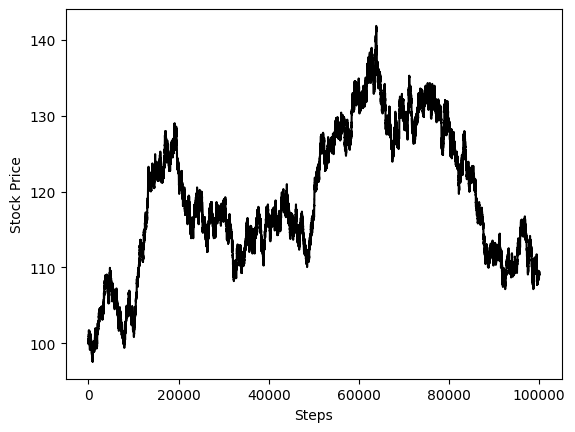

In [19]:
import matplotlib.pyplot as plt

N=100000
sigma = 0.4
T = 0.5
K = 105
r= 0.05
dt = T / N
Heads = np.exp(sigma * np.sqrt(dt))
Tails = np.exp(-sigma * np.sqrt(dt))
S0 = 100
p = (  np.exp(r*dt) - Tails )  /  ( Heads - Tails )
paths = np.random.choice([Heads,Tails],p=[p,1-p],size=(N,1))
plt.plot(paths.cumprod(axis=0)*100, color='black');
plt.xlabel('Steps')
plt.ylabel('Stock Price')

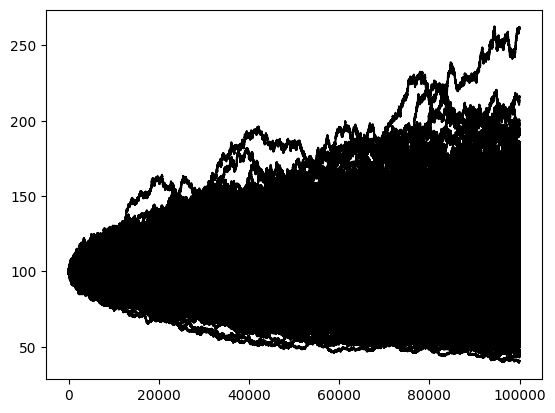

In [20]:
paths = np.random.choice([Heads,Tails],p=[p,1-p],size=(N,1000))
plt.plot(paths.cumprod(axis=0)*100, color='black');

---

# Pricing Real Options on Yahoo Finance

In [3]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime as dt
import math

import matplotlib.pyplot as plt


def combos(n, i):
    return math.factorial(n) / (math.factorial(n-i)*math.factorial(i))



def binom_EU1(S0, K , T, r, sigma, N, type_ = 'call'):
    dt = T/N
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))
    p = (  np.exp(r*dt) - d )  /  (  u - d )
    value = 0 
    for i in range(N+1):
        node_prob = combos(N, i)*p**i*(1-p)**(N-i)
        ST = S0*(u)**i*(d)**(N-i)
        if type_ == 'call':
            value += max(ST-K,0) * node_prob
        elif type_ == 'put':
            value += max(K-ST, 0)*node_prob
        else:
            raise ValueError("type_ must be 'call' or 'put'" )
    
    return value*np.exp(-r*T)


def get_data(symbol):
    obj = web.YahooOptions(f'{symbol}')
    obj.headers = {'User-Agent': 'Firefox'}
    
    df = obj.get_all_data()

    df.reset_index(inplace=True)

    df['mid_price'] = (df.Ask+df.Bid) / 2
    df['Time'] = (df.Expiry - dt.datetime.now()).dt.days / 255
    
    return df[(df.Bid>0) & (df.Ask >0)]




In [4]:
df = get_data('TSLA')


RemoteDataError: Unable to read URL: https://query1.finance.yahoo.com/v7/finance/options/TSLA
Response Text:
b'{"finance":{"result":null,"error":{"code":"Unauthorized","description":"Invalid Crumb"}}}'

In [ ]:

df = get_data('TSLA')

prices = [] 


for row in df.itertuples():
    price = binom_EU1(row.Underlying_Price, row.Strike, row.Time, 0.01, 0.5, 20, row.Type)
    prices.append(price)
    
    
df['Price'] = prices
    
df['error'] = df.mid_price - df.Price 
    
    
exp1 = df[(df.Expiry == df.Expiry.unique()[2]) & (df.Type=='call')]


plt.plot(exp1.Strike, exp1.mid_price,label= 'Mid Price')
plt.plot(exp1.Strike, exp1.Price, label = 'Calculated Price')
plt.xlabel('Strike')
plt.ylabel('Call Value')
plt.legend()
